In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt 

In [2]:
# Load the MATLAB file 
EEG_data = loadmat('/home/costanza/thesis/Datasets/BCI_Competition_IV/calib/BCICIV_1_mat/BCICIV_calib_ds1d.mat', struct_as_record = True)

# List all the keys in the loaded data
keys = EEG_data.keys()

# Print the keys variables to identify the correct key for EEG data
print(keys)

dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'cnt', 'nfo'])


In [3]:
# Extract data
markers = EEG_data['mrk']
sfreq = EEG_data['nfo']['fs'][0][0][0][0]
EEGdata   = EEG_data['cnt'].T 
nchannels, nsamples = EEGdata.shape

time_unit = 1 / sfreq
print("Time Unit:", time_unit, "seconds")

chan_names = [s[0] for s in EEG_data['nfo']['clab'][0][0][0]]

event_onsets  = EEG_data['mrk'][0][0][0] # Time points when events occurred
event_codes   = EEG_data['mrk'][0][0][1] # It contains numerical or categorical labels associated with each event.
event_onset_time = event_onsets * time_unit # Seconds

# Creates an array of zeros and then assigns the event codes to the corresponding positions based on the event onsets.
labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

cl_lab = [s[0] for s in EEG_data['nfo']['classes'][0][0][0]]
cl1    = cl_lab[0]
cl2    = cl_lab[1]

# Electrode positions 
xpos = EEG_data['nfo']['xpos']
ypos = EEG_data['nfo']['ypos']

nclasses = len(cl_lab)
nevents = len(event_onsets)

# Print some information
print('Shape of EEG:', EEGdata.shape)
print('Sample rate:', sfreq)
print('Number of channels:', nchannels)
print('Channel names:', chan_names)
print('Number of events (MI movements):', event_onsets.shape[1])
print('Event codes:', np.unique(event_codes))
print('Class labels:', cl_lab)
print('Number of classes:', nclasses)


Time Unit: 0.01 seconds
Shape of EEG: (59, 190473)
Sample rate: 100
Number of channels: 59
Channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Number of events (MI movements): 200
Event codes: [-1  1]
Class labels: ['left', 'right']
Number of classes: 2


In [4]:
# Segmentation

# Dictionary to store the trials in, each class gets an entry
trials = {}

# The time window (in samples) to extract for each trial, here 0.5 -- 4.5 seconds
win = np.arange(int(0.5*sfreq), int(4.5*sfreq)) # 400 samples
nsamples_win = len(win)


In [5]:
# Loop over the classes (left, foot)
for cl, code in zip(cl_lab, np.unique(event_codes)):

    # Extract the onsets for the class
    cl_onsets = event_onsets[event_codes == code]

    # Allocate memory for the trials
    trials[cl] = np.zeros((nchannels, nsamples_win, len(cl_onsets)))

    # Extract each trial
    for i, onset in enumerate (cl_onsets):
        trials[cl][:,:,i] = EEGdata[:,win + onset]

print('Shape of trials[cl1]:', trials[cl1].shape)
print('Shape of trials[cl2]:', trials[cl2].shape)

Shape of trials[cl1]: (59, 400, 100)
Shape of trials[cl2]: (59, 400, 100)


In [6]:
left  = np.rollaxis(trials[cl1], 2, 0)  
right = np.rollaxis(trials[cl2], 2, 0)
data = np.concatenate([left, right])

Y = np.concatenate([-np.ones(left.shape[0]), np.ones(right.shape[1])])

print(data.shape)
print(Y.shape)

(200, 59, 400)
(159,)


In [7]:
import mne

In [8]:
n_channels = 59

# Initialize an info structure
info = mne.create_info(
    ch_names = chan_names,
    ch_types = ['eeg'] * nchannels,
    sfreq = sfreq
)

print('Event created:', info)

Event created: <Info | 7 non-empty values
 bads: []
 ch_names: AF3, AF4, F5, F3, F1, Fz, F2, F4, F6, FC5, FC3, FC1, FCz, FC2, ...
 chs: 59 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: unspecified
 nchan: 59
 projs: []
 sfreq: 100.0 Hz
>


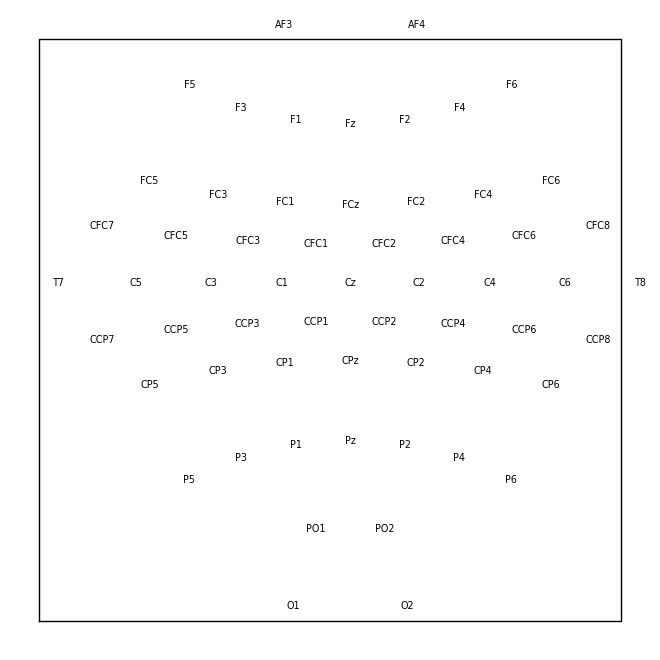

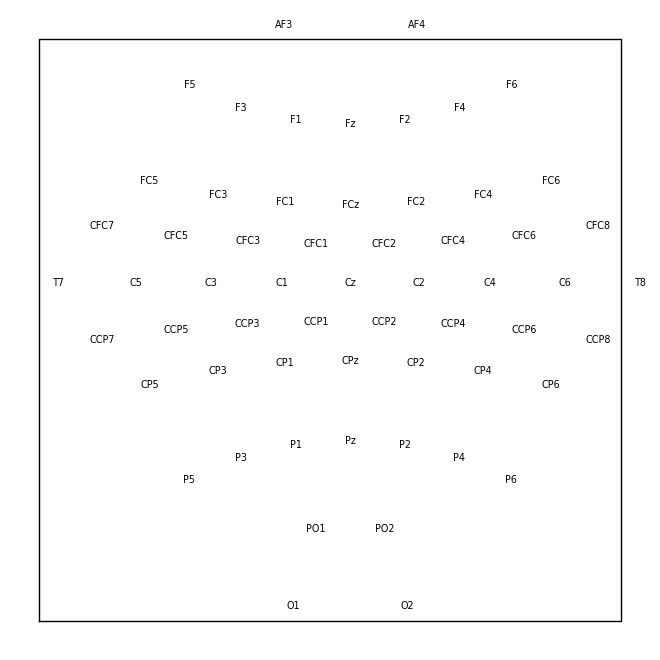

In [9]:
xpos = EEG_data['nfo']['xpos'][0][0]
ypos = EEG_data['nfo']['ypos'][0][0]
layout_pos = np.concatenate((xpos, ypos), axis = 1)

layout = mne.channels.generate_2d_layout(
    xy = layout_pos,
    ch_names = chan_names,
    name = 'EEG custom layout',
)

layout.plot()

In [17]:
from matplotlib import pyplot as plt
import distinctipy

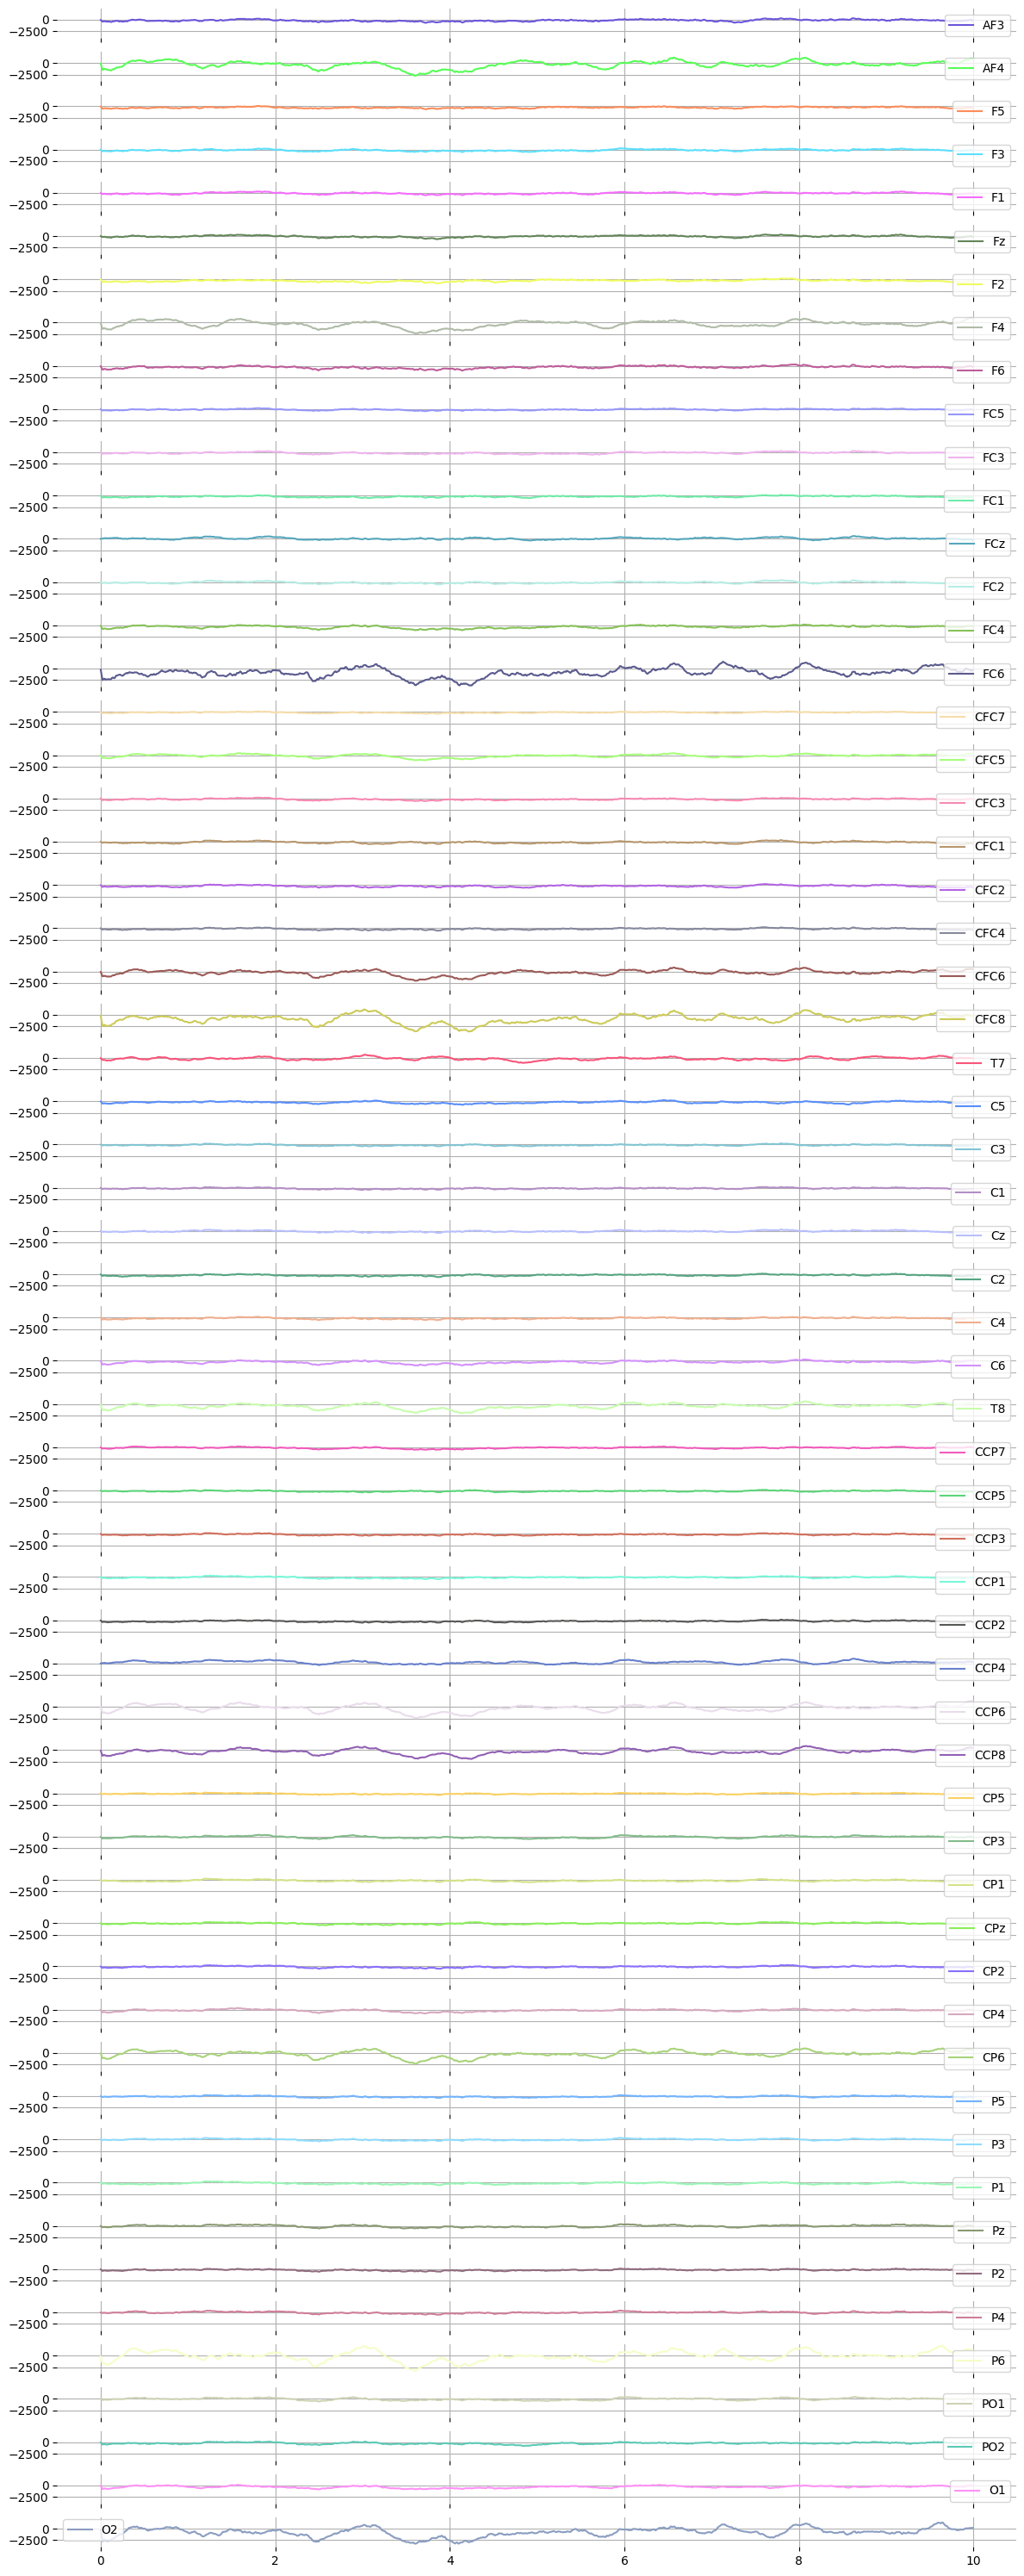

In [20]:
# Define the number of subplots
num_subplots = nchannels
num_cols = 1  # Number of columns in the subplot grid
num_rows = int(np.ceil(num_subplots / num_cols))

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 30), sharex=True, sharey=True)

# Flatten the axes array if there is more than one row
axes = axes.flatten()

npoints = 1000

colors = distinctipy.get_colors(nchannels, pastel_factor=0.5)
x = (np.arange(nsamples) * time_unit)[:npoints]

# Plot EEG data for each channel
for i, ax in enumerate(axes[:num_subplots]):
    ax.plot(x, EEGdata[i, :npoints], label=chan_names[i], color=colors[i])
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()